In [2]:
from astropy.io import fits
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import subprocess
from sklearn.cluster import DBSCAN
from analyzeImage import analyzeImage


In [9]:
gpu_code_path = "../code/gpu/"
real_image_name = "chip_7"
real_image_path = gpu_code_path+"images/"+real_image_name
psi_image_path = gpu_code_path+"output-images/psi"
phi_image_path = gpu_code_path+"output-images/phi"

In [25]:
paramsFile = open('../code/gpu/debug/parameters.config', 'w')
paramsFile.write(
"""Debug ................ : 1
Image Count .......... : 5
Generate Images ...... : 1
Image Width .......... : 1000
Image Height ......... : 1000
PSF Sigma ............ : 1.0
Object Brightness .... : 2500.0
Object Initial x ..... : 150.0
Object Initial y ..... : 100.0
Velocity x ........... : 200.0
Velocity y ........... : -250.0
Background Level ..... : 1024.0
Background Sigma ..... : 32.0
Mask Threshold ....... : 40.0
Mask Penalty ......... : -0.012
Angles to Search ..... : 80
Velocities to Search . : 30
Minimum Velocity ..... : 270.0
Maximum Velocity ..... : 600.0
Write to file ........ : 1
Source Images Path ... : ../../{source}/
Psi Images Path ...... : ../../{psi}/
Phi Images Path....... : ../../{phi}/
""".format( source=real_image_path, psi=psi_image_path, phi=phi_image_path ))
paramsFile.close()

In [21]:
os.system("../code/gpu/debug/clearImages.sh")

os.system("../code/gpu/debug/CudaTracker")

34304

In [18]:
results = np.genfromtxt('../code/gpu/debug/results/results.txt', names=True)

In [19]:
print(results)

[(1085811578.0, 1485.0, 0.0, 0.0, 0.0, 0.0, 542.429, 0.0)
 (1088000071.0, 1506.0, 0.0, 0.0, 0.0, 0.0, 542.429, 0.0)
 (1088170415.0, 172.0, 0.0, 0.0, 0.0, 0.0, 542.429, 0.0) ...,
 (1092377928.0, 952.0, 0.0, 0.0, 0.0, 0.0, 267.812, 97.476)
 (1089376404.0, 578.0, 0.0, 0.0, 0.0, 0.0, 267.812, -97.476)
 (1091725286.0, 910.0, 0.0, 0.0, 0.0, 0.0, 267.812, 97.476)]


In [10]:
image_mjd = []

for filename in sorted(os.listdir(real_image_path)):
    hdulist = fits.open(os.path.join(real_image_path, filename))
    image_mjd.append(hdulist[0].header['MJD'])

image_mjd = np.array(image_mjd)
image_times = image_mjd - image_mjd[0]
#image_times*=24.


In [11]:
hdulist = fits.open(os.path.join(psi_image_path, os.listdir(psi_image_path)[0]))
num_images = len(os.listdir(psi_image_path))
image_shape = np.shape(hdulist[0].data)
im_psi_array = np.zeros((num_images, image_shape[0], image_shape[1]))


for idx, filename in list(enumerate(sorted(os.listdir(psi_image_path)))):

    print str('Loaded ' + filename)

    image_file = os.path.join(psi_image_path, filename)
    hdulist = fits.open(image_file)
    im_psi_array[idx] = hdulist[0].data#*mask


Loaded T001psi.fits
Loaded T002psi.fits
Loaded T003psi.fits
Loaded T004psi.fits
Loaded T005psi.fits
Loaded T006psi.fits
Loaded T007psi.fits
Loaded T008psi.fits
Loaded T009psi.fits
Loaded T010psi.fits
Loaded T011psi.fits
Loaded T012psi.fits
Loaded T013psi.fits
Loaded T014psi.fits
Loaded T015psi.fits
Loaded T016psi.fits
Loaded T017psi.fits
Loaded T018psi.fits
Loaded T019psi.fits
Loaded T020psi.fits
Loaded T021psi.fits
Loaded T022psi.fits
Loaded T023psi.fits
Loaded T024psi.fits
Loaded T025psi.fits
Loaded T026psi.fits
Loaded T027psi.fits
Loaded T028psi.fits
Loaded T029psi.fits
Loaded T030psi.fits
Loaded T031psi.fits
Loaded T032psi.fits
Loaded T033psi.fits
Loaded T034psi.fits
Loaded T035psi.fits
Loaded T036psi.fits
Loaded T037psi.fits
Loaded T038psi.fits
Loaded T039psi.fits
Loaded T040psi.fits
Loaded T041psi.fits
Loaded T042psi.fits
Loaded T043psi.fits
Loaded T044psi.fits
Loaded T045psi.fits
Loaded T046psi.fits
Loaded T047psi.fits
Loaded T048psi.fits
Loaded T049psi.fits
Loaded T050psi.fits


In [12]:
hdulist = fits.open(os.path.join(phi_image_path, os.listdir(phi_image_path)[0]))
num_images = len(os.listdir(phi_image_path))
image_shape = np.shape(hdulist[0].data)
im_phi_array = np.zeros((num_images, image_shape[0], image_shape[1]))


for idx, filename in list(enumerate(sorted(os.listdir(phi_image_path)))):

    print str('Loaded ' + filename)

    image_file = os.path.join(phi_image_path, filename)
    hdulist = fits.open(image_file)
    im_phi_array[idx] = hdulist[0].data#*mask


Loaded T001phi.fits
Loaded T002phi.fits
Loaded T003phi.fits
Loaded T004phi.fits
Loaded T005phi.fits
Loaded T006phi.fits
Loaded T007phi.fits
Loaded T008phi.fits
Loaded T009phi.fits
Loaded T010phi.fits
Loaded T011phi.fits
Loaded T012phi.fits
Loaded T013phi.fits
Loaded T014phi.fits
Loaded T015phi.fits
Loaded T016phi.fits
Loaded T017phi.fits
Loaded T018phi.fits
Loaded T019phi.fits
Loaded T020phi.fits
Loaded T021phi.fits
Loaded T022phi.fits
Loaded T023phi.fits
Loaded T024phi.fits
Loaded T025phi.fits
Loaded T026phi.fits
Loaded T027phi.fits
Loaded T028phi.fits
Loaded T029phi.fits
Loaded T030phi.fits
Loaded T031phi.fits
Loaded T032phi.fits
Loaded T033phi.fits
Loaded T034phi.fits
Loaded T035phi.fits
Loaded T036phi.fits
Loaded T037phi.fits
Loaded T038phi.fits
Loaded T039phi.fits
Loaded T040phi.fits
Loaded T041phi.fits
Loaded T042phi.fits
Loaded T043phi.fits
Loaded T044phi.fits
Loaded T045phi.fits
Loaded T046phi.fits
Loaded T047phi.fits
Loaded T048phi.fits
Loaded T049phi.fits
Loaded T050phi.fits


In [13]:
hdulist = fits.open(os.path.join(real_image_path, os.listdir(real_image_path)[0]))
num_images = len(os.listdir(real_image_path))
image_shape = np.shape(hdulist[1].data)
im_array = np.zeros((num_images, image_shape[0], image_shape[1]))


for idx, filename in list(enumerate(sorted(os.listdir(real_image_path)))):

    print str('Loaded ' + filename)

    image_file = os.path.join(real_image_path, filename)
    hdulist = fits.open(image_file)
    im_array[idx] = hdulist[1].data#*mask


Loaded CORR40535777.fits
Loaded CORR40535787.fits
Loaded CORR40535797.fits
Loaded CORR40535807.fits
Loaded CORR40535817.fits
Loaded CORR40535827.fits
Loaded CORR40535837.fits
Loaded CORR40535847.fits
Loaded CORR40535857.fits
Loaded CORR40535867.fits
Loaded CORR40535877.fits
Loaded CORR40535887.fits
Loaded CORR40535897.fits
Loaded CORR40535907.fits
Loaded CORR40535917.fits
Loaded CORR40535927.fits
Loaded CORR40535937.fits
Loaded CORR40535947.fits
Loaded CORR40535957.fits
Loaded CORR40535967.fits
Loaded CORR40535977.fits
Loaded CORR40535987.fits
Loaded CORR40535997.fits
Loaded CORR40536007.fits
Loaded CORR40536017.fits
Loaded CORR40536027.fits
Loaded CORR40536037.fits
Loaded CORR40536047.fits
Loaded CORR40536057.fits
Loaded CORR40536067.fits
Loaded CORR40536077.fits
Loaded CORR40536087.fits
Loaded CORR40536097.fits
Loaded CORR40536107.fits
Loaded CORR40536117.fits
Loaded CORR40536127.fits
Loaded CORR40536137.fits
Loaded CORR40536147.fits
Loaded CORR40536157.fits
Loaded CORR40536167.fits


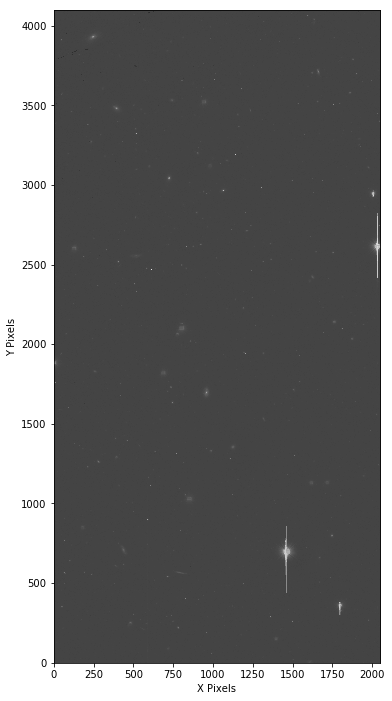

In [33]:
fig = plt.figure(figsize=(12,12))
plt.imshow(im_array[2], origin='lower', cmap=plt.cm.Greys_r)
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

In [34]:
results[['t0_x', 't0_y']]
#results[29]

array([(596.0, 1849.0), (598.0, 1849.0), (1879.0, 2107.0), ...,
       (1370.0, 2797.0), (1407.0, 2798.0), (647.0, 1875.0)], 
      dtype=[('t0_x', '<f8'), ('t0_y', '<f8')])

In [14]:
ai = analyzeImage()

In [20]:
stamp_count = 50
arg = dict(eps=0.05, min_samples=1, n_jobs=-1)
best_targets = ai.clusterResults(results, dbscan_args=arg)#, im_array, image_times)
best_targets = best_targets[1]
#best_targets = range(stamp_count)
#best_targets

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [37]:
print (len(best_targets))
best_targets

148


[0,
 2,
 3079,
 3436,
 5250,
 5906,
 12608,
 17652,
 19032,
 25101,
 29554,
 30009,
 30288,
 30334,
 31444,
 31466,
 32212,
 33086,
 33293,
 34554,
 35424,
 36462,
 36596,
 36739,
 37041,
 37825,
 38262,
 38374,
 38596,
 38703,
 39745,
 39902,
 40038,
 40140,
 40201,
 40337,
 40354,
 40373,
 40929,
 41084,
 41116,
 41452,
 41473,
 41659,
 41924,
 42034,
 42068,
 42093,
 42115,
 42369,
 42403,
 42549,
 42661,
 42690,
 42844,
 42954,
 42978,
 43083,
 43715,
 43806,
 43831,
 43834,
 43945,
 44036,
 44197,
 44296,
 44643,
 44648,
 44678,
 44872,
 45067,
 45279,
 45286,
 45330,
 45431,
 45462,
 45492,
 45494,
 45537,
 45552,
 45561,
 45566,
 45631,
 45921,
 45968,
 46249,
 46363,
 46476,
 46484,
 46661,
 46781,
 46787,
 47004,
 47028,
 47037,
 47079,
 47090,
 47119,
 47166,
 47190,
 47309,
 47387,
 47409,
 47450,
 47504,
 47528,
 47664,
 47675,
 47761,
 47781,
 47800,
 47874,
 47944,
 47985,
 48085,
 48160,
 48177,
 48239,
 48287,
 48385,
 48426,
 48470,
 48528,
 48546,
 48584,
 48657,
 487

In [38]:
list(results[['t0_x', 't0_y']][29])

[1901.0, 2102.0]

In [39]:
np.array(list(results[['v_x', 'v_y']][29]))

array([  87.967,  270.734])

In [40]:
image_times

array([ 0.      ,  0.003054,  0.006087,  0.009132,  0.012176,  0.015208,
        0.018259,  0.021283,  0.024324,  0.02736 ,  0.030406,  0.033434,
        0.036469,  0.039509,  0.042539,  0.045585,  0.048615,  0.05166 ,
        0.054679,  0.057738,  0.06077 ,  0.063814,  0.06686 ,  0.069889,
        0.07292 ,  0.075965,  0.078999,  0.08204 ,  0.085056,  0.088114,
        0.091128,  0.094168,  0.097206,  0.100257,  0.10328 ,  0.106321,
        0.109352,  0.112373,  0.115429,  0.118454,  0.121503,  0.124518,
        0.127565,  0.130589,  0.133609,  0.136663,  0.139679,  0.142729,
        0.145751,  0.148771,  0.151825,  0.154844,  0.157897,  0.160916,
        0.16396 ])

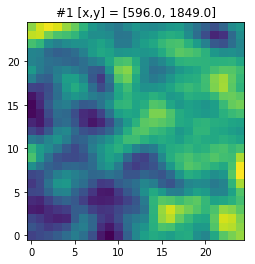

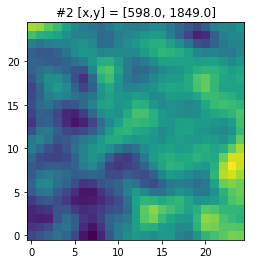

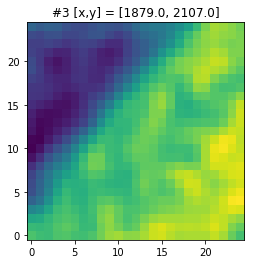

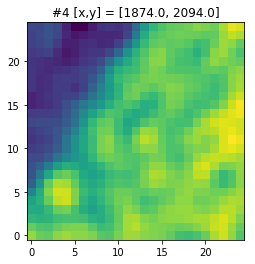

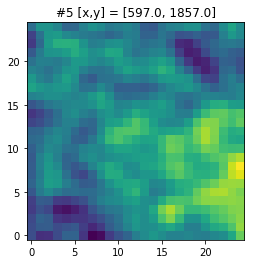

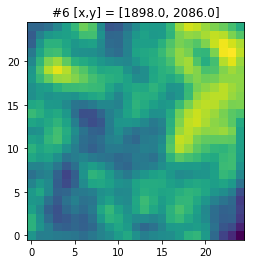

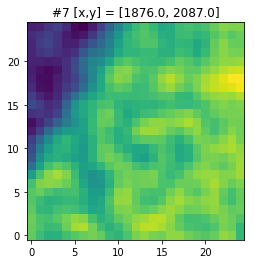

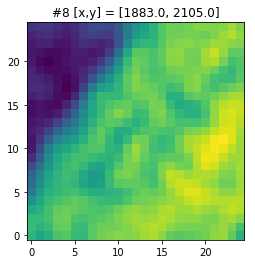

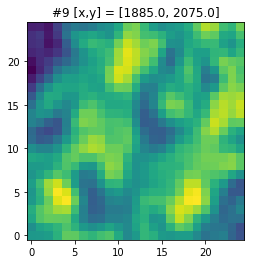

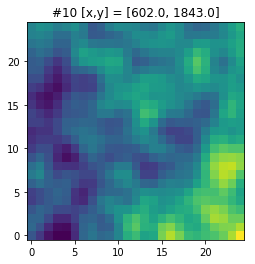

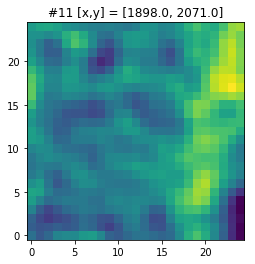

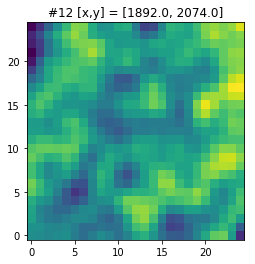

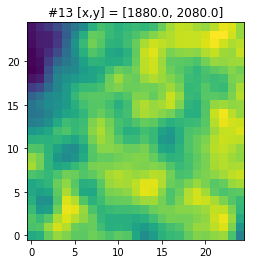

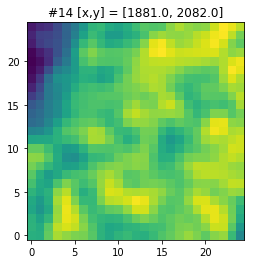

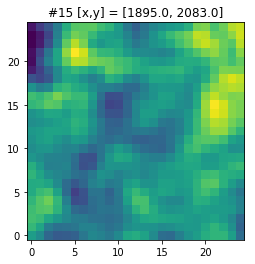

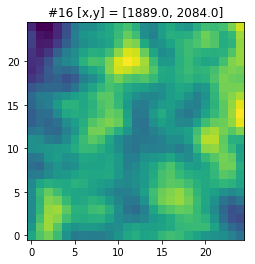

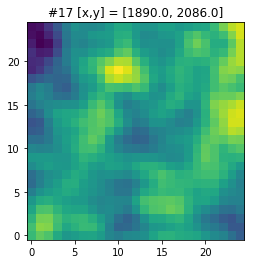

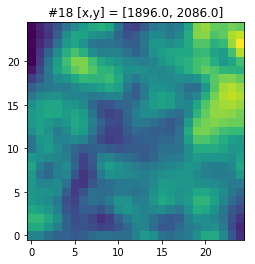

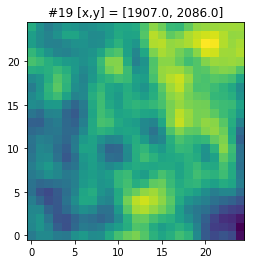

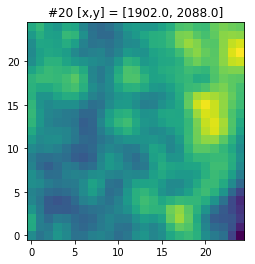

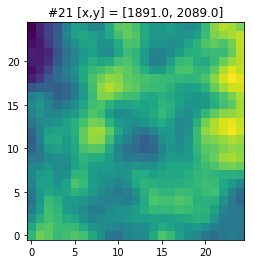

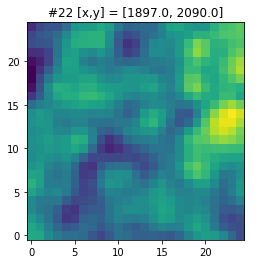

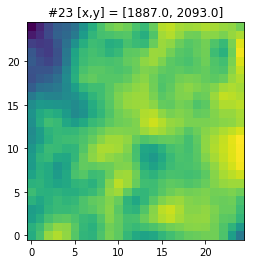

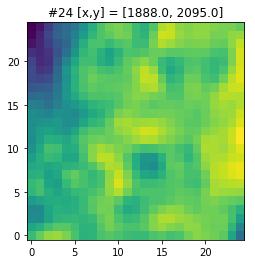

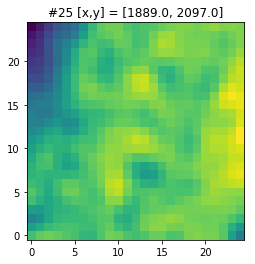

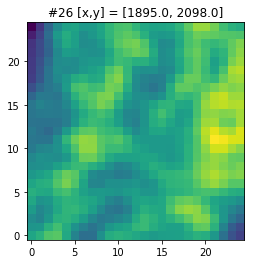

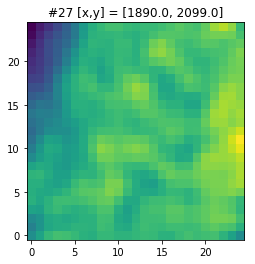

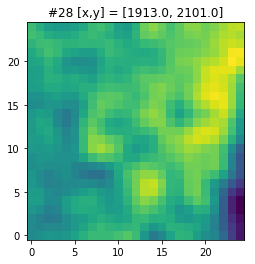

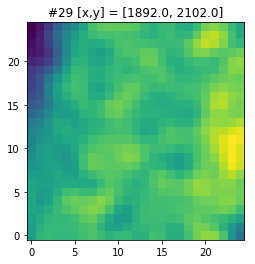

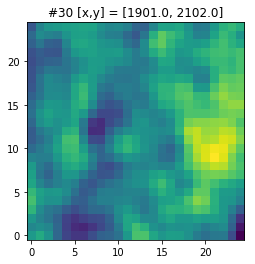

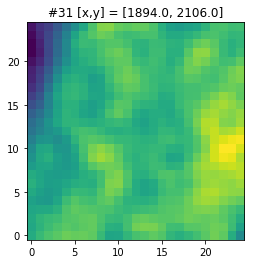

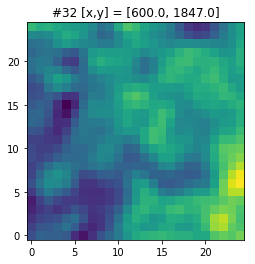

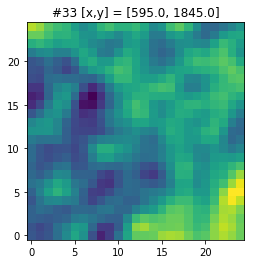

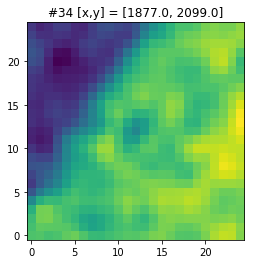

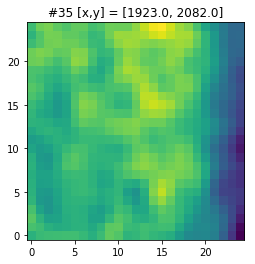

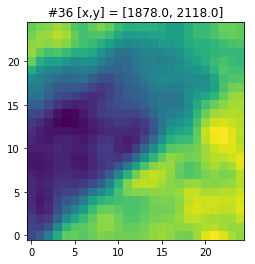

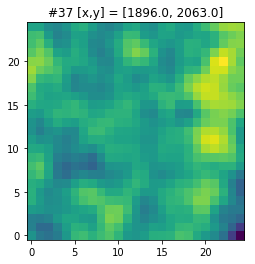

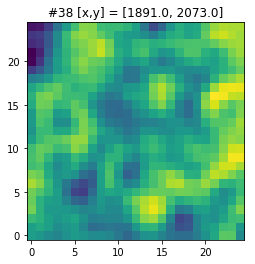

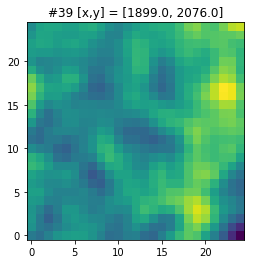

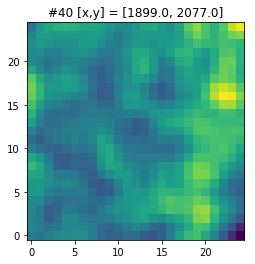

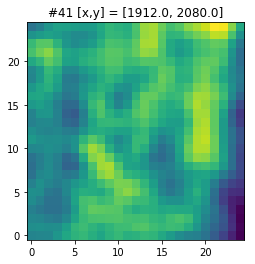

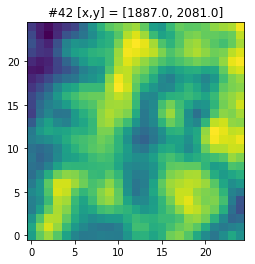

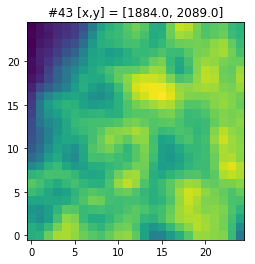

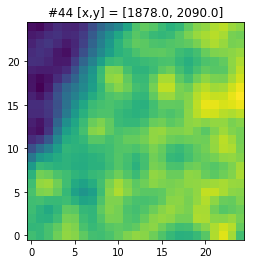

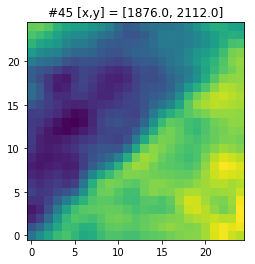

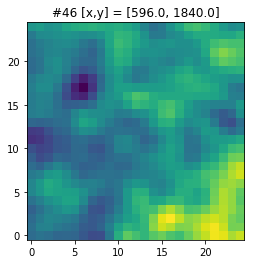

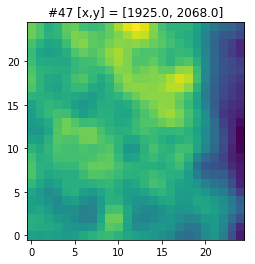

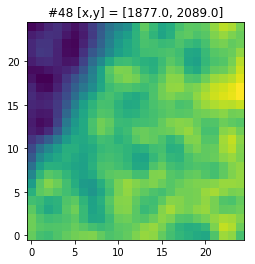

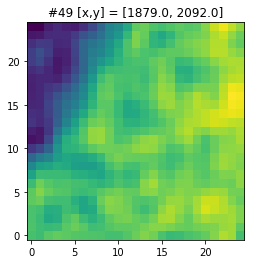

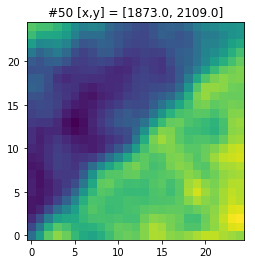

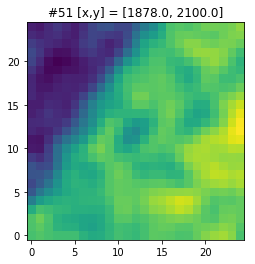

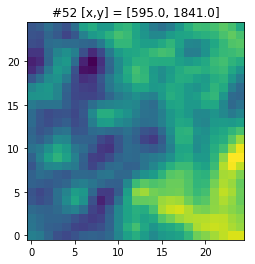

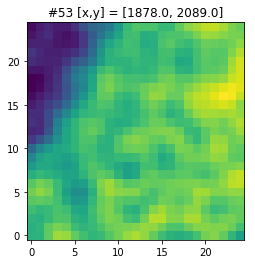

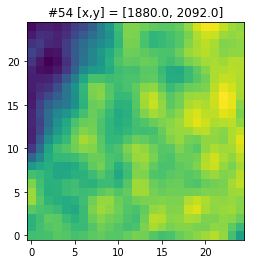

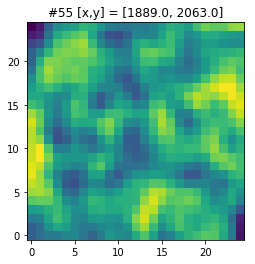

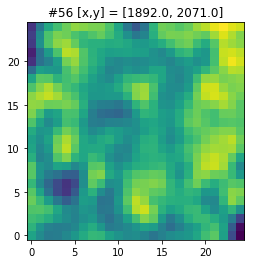

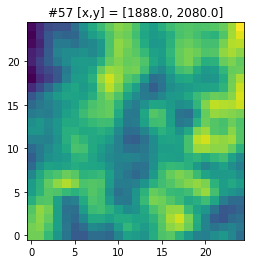

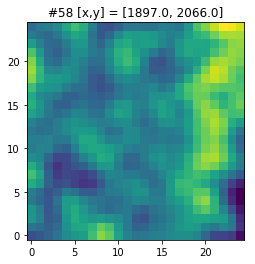

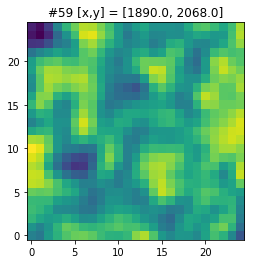

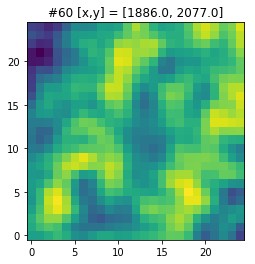

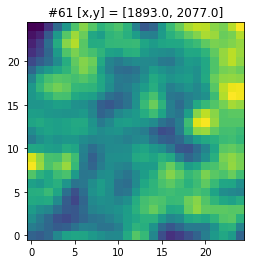

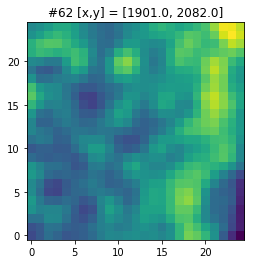

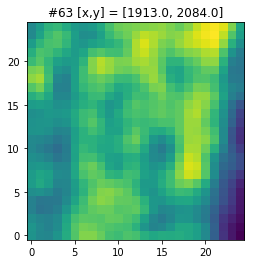

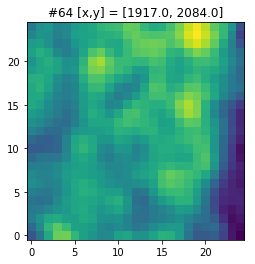

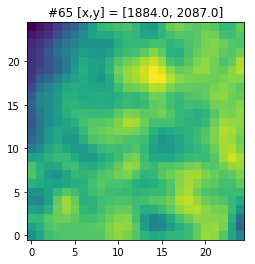

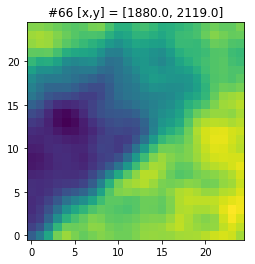

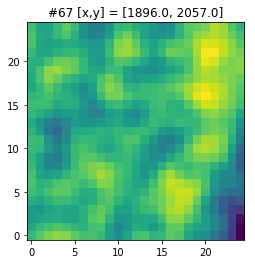

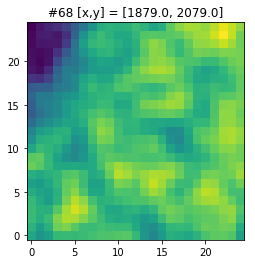

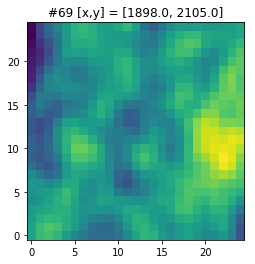

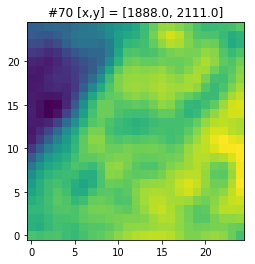

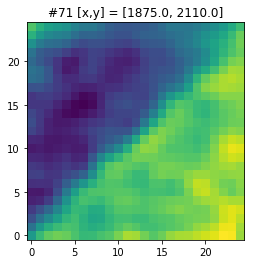

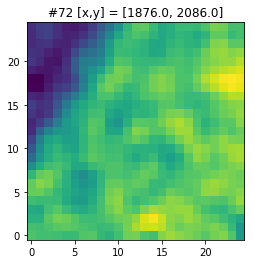

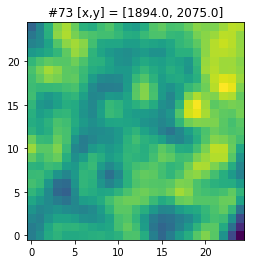

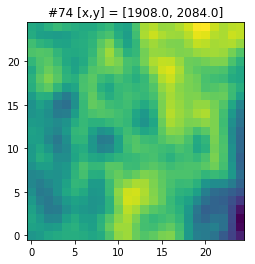

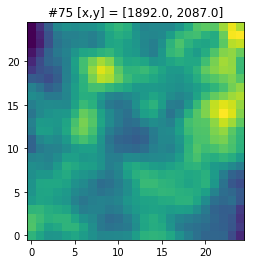

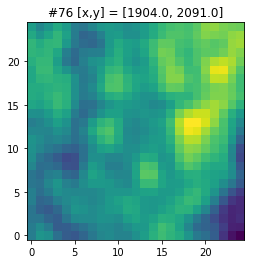

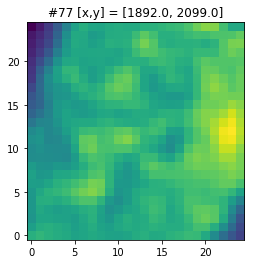

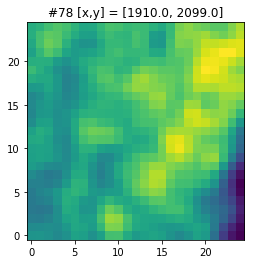

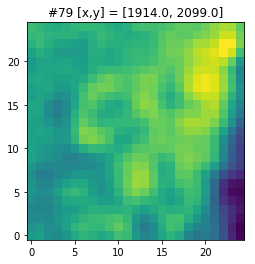

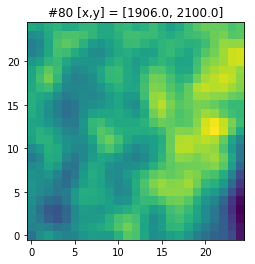

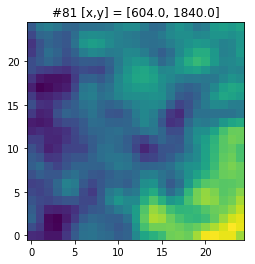

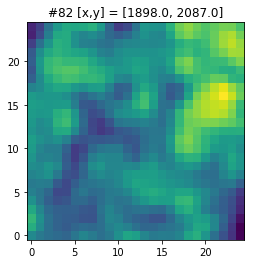

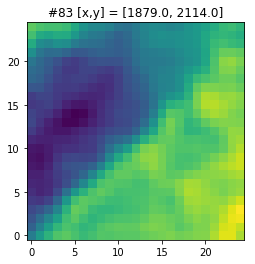

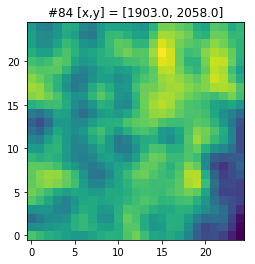

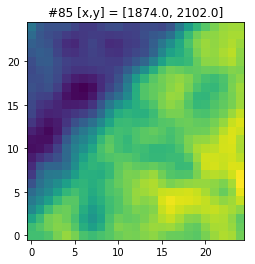

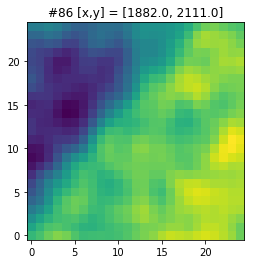

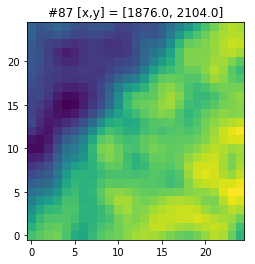

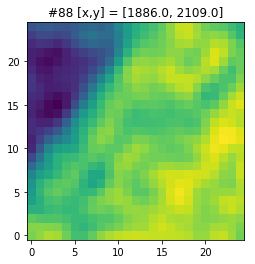

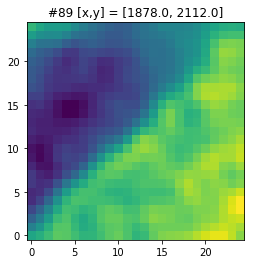

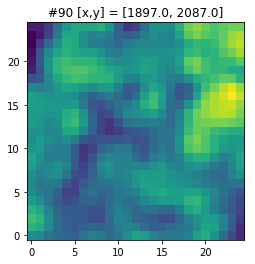

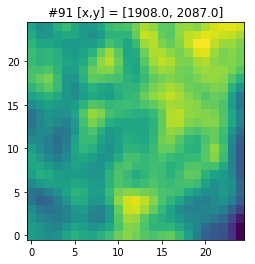

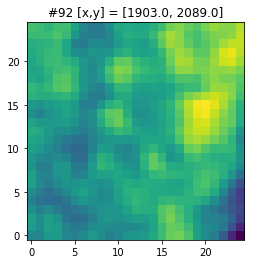

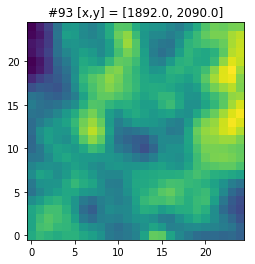

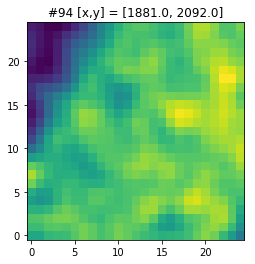

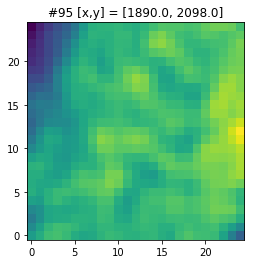

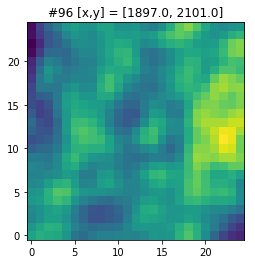

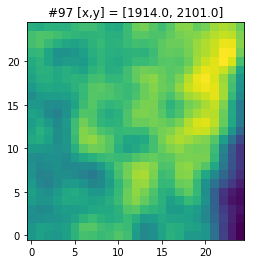

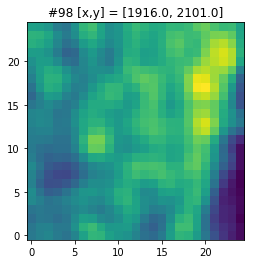

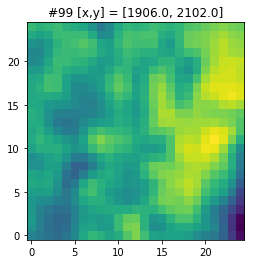

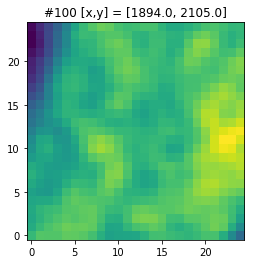

In [44]:
for imNum in range(100):
    current = imNum#best_targets[imNum]
    
    plt.imshow(ai.createPostageStamp(im_psi_array,
                                         list(results[['t0_x', 't0_y']][current]),
                                         np.array(list(results[['v_x', 'v_y']][current])),
                                         image_times*1, [25., 25.])[0],
                    origin='lower',
              # cmap=plt.cm.Greys_r,
               interpolation='None')
    plt.title(str('#' + str(imNum+1) + ' [x,y] = ' + str(list(results[['t0_x', 't0_y']][current]))))
 #   plt.savefig("stamps/stamp"+str(imNum+1)+".png")
    plt.show()


In [22]:
fig = plt.figure(figsize=(25,25))
im_per_line = 5
grid = gridspec.GridSpec(10, 7, wspace=2.0, hspace=2.0)
for imNum in range(stamp_count):
    fig.add_subplot(grid[imNum])#outmath.floor(stamp_count/im_per_line),im_per_line,imNum+1)
    try:
        plt.imshow(ai.createPostageStamp(im_array, 
                                     list(results[['t0_x', 't0_y']][best_targets[imNum]]),
                                     list(results[['v_x', 'v_y']][best_targets[imNum]]),
                                     image_times, [25., 25.])[0],
                origin='lower', cmap=plt.cm.Greys_r, interpolation='None')
        plt.title(str(' [x,y] = ' + str(list(results[['t0_x', 't0_y']][best_targets[imNum]]))))
        plt.savefig("test.png")#stamp"+imNum+".png")
    except:
        print "oh no!"
        continue
#plt.tight_layout(outer_grid)


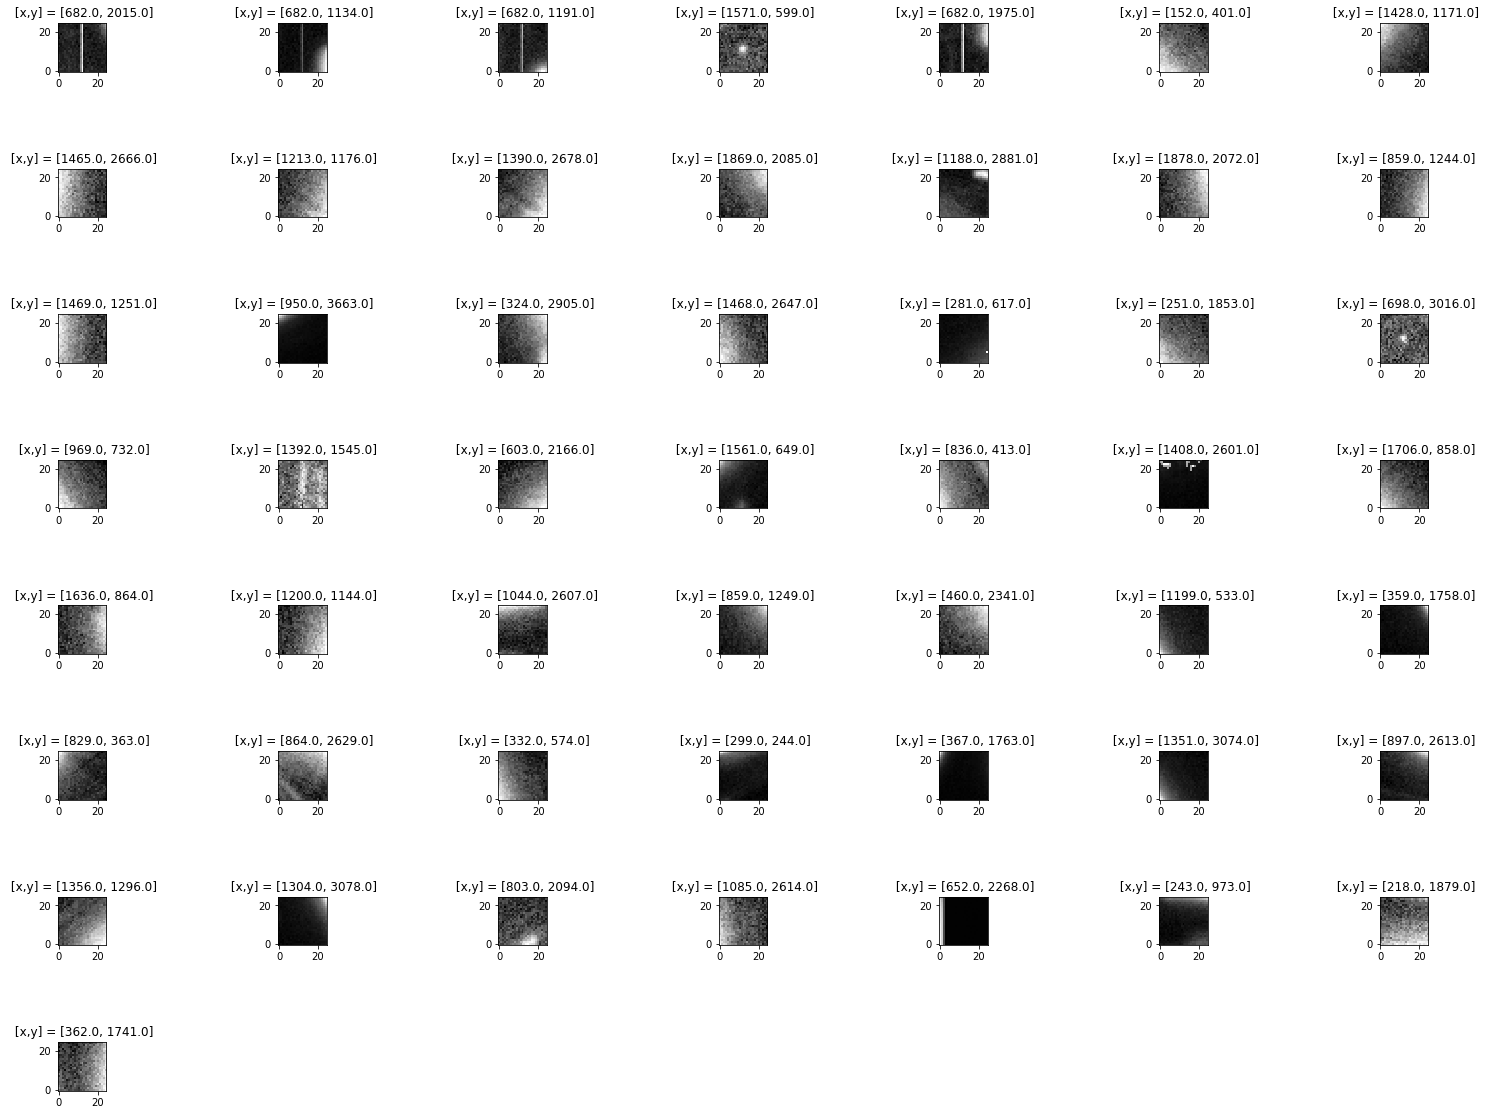

In [17]:
fig = plt.figure(figsize=(25,25))
im_per_line = 5
grid = gridspec.GridSpec(10, 7, wspace=2.0, hspace=2.0)
for imNum in range(stamp_count):
    fig.add_subplot(grid[imNum])#outmath.floor(stamp_count/im_per_line),im_per_line,imNum+1)
    try:
        plt.imshow(ai.createPostageStamp(im_array, 
                                     list(results[['t0_x', 't0_y']][best_targets[imNum]]),
                                     list(results[['v_x', 'v_y']][best_targets[imNum]]),
                                     image_times, [25., 25.])[0],
                origin='lower', cmap=plt.cm.Greys_r, interpolation='None')
        plt.title(str(' [x,y] = ' + str(list(results[['t0_x', 't0_y']][best_targets[imNum]]))))
    except:
        print "oh no!"
        continue
#plt.tight_layout(outer_grid)
plt.show()